In [6]:
#Necessary packages:
import warnings
warnings.filterwarnings("ignore")
import os
import shutil
import cv2 
import glob
import urllib.request
from random import shuffle
import numpy as np
import pandas as pd
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [5]:
#Files names in the main folder:
print(os.listdir(r"D:\NLP\Healthcare\chest_xray\train\\"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


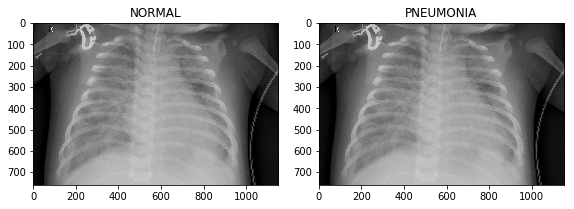

In [7]:
#Visualizing some images using matplotlib
img_normal = plt.imread(r"D:\NLP\Healthcare\chest_xray\train\PNEUMONIA\person1000_bacteria_2931.jpeg")
img_penumonia_bacteria = plt.imread(r"D:\NLP\Healthcare\chest_xray\train\PNEUMONIA\person1000_bacteria_2931.jpeg")

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.tight_layout()

In [13]:
#Setting directories for test and training datasets
TRAIN_DIR =r"D:\NLP\Healthcare\chest_xray\train"
TEST_DIR =r"D:\NLP\Healthcare\chest_xray\test"

In [8]:
#Labeling data (creating dependant feature)
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [9]:
#making data arrays and labeling images:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [10]:
#Giving data the suitable format
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir +"\\"+nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp +"\\"+ file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [21]:
#Getting training data
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 3876/3876 [05:08<00:00, 12.19it/s]


In [15]:
#Getting test data
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 390/390 [00:29<00:00, 12.92it/s]


In [22]:
#data shape 
print(X_train.shape,'\n',X_test.shape)
print(y_train.shape,'\n',y_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)
(5216,) 
 (624, 2, 2)


In [24]:
#transforming dependant feature to a new one with 2 dimensions
from keras.utils.np_utils import to_categorical
warnings.filterwarnings("ignore")
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [25]:
y_train.shape

(5216, 2)

In [26]:
#defining path to each image
Pimages = os.listdir(TRAIN_DIR +"\\"+"PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR +"\\"+ "NORMAL")

In [27]:
#Building the traing model:calling the necessary component,and making the architecture
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [30]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [28]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [29]:
#data format
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [30]:
warnings.filterwarnings("ignore")
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

W0928 11:17:17.106752 18240 module_wrapper.py:137] From C:\Users\abdellaouia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0928 11:17:24.204443 18240 module_wrapper.py:137] From C:\Users\abdellaouia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0928 11:17:24.487024 18240 deprecation.py:506] From C:\Users\abdellaouia\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0928 11:17:24.518902 18240 module_wrapper.py:137] From C:\Users\abdellaouia\AppD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 37, 37)        18496     
__________

In [37]:
#Definig batch and epoch
batch_size = 256
epochs = 6

In [38]:
#Training the model on training data and using test data for validation
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - ETA: 10:49 - loss: 0.6934 - acc: 0.50 - ETA: 7:35 - loss: 0.6922 - acc: 0.5234 - ETA: 6:28 - loss: 0.6915 - acc: 0.567 - ETA: 5:53 - loss: 0.6897 - acc: 0.628 - ETA: 5:37 - loss: 0.6878 - acc: 0.653 - ETA: 5:22 - loss: 0.6842 - acc: 0.692 - ETA: 5:15 - loss: 0.6805 - acc: 0.714 - ETA: 5:11 - loss: 0.6769 - acc: 0.722 - ETA: 5:07 - loss: 0.6737 - acc: 0.729 - ETA: 5:00 - loss: 0.6659 - acc: 0.750 - ETA: 4:54 - loss: 0.6619 - acc: 0.755 - ETA: 4:48 - loss: 0.6596 - acc: 0.752 - ETA: 4:44 - loss: 0.6546 - acc: 0.754 - ETA: 4:39 - loss: 0.6525 - acc: 0.752 - ETA: 4:35 - loss: 0.6513 - acc: 0.747 - ETA: 4:30 - loss: 0.6507 - acc: 0.742 - ETA: 4:28 - loss: 0.6472 - acc: 0.742 - ETA: 4:25 - loss: 0.6418 - acc: 0.744 - ETA: 4:23 - loss: 0.6384 - acc: 0.745 - ETA: 4:20 - loss: 0.6400 - acc: 0.740 - ETA: 4:17 - loss: 0.6392 - acc: 0.739 - ETA: 4:14 - loss: 0.6345 - acc: 0.742 - ETA: 4:11 - loss:

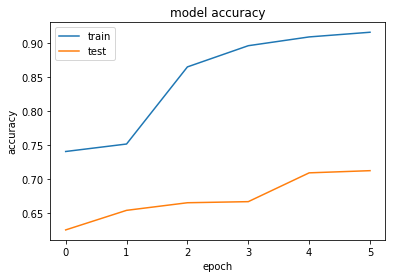

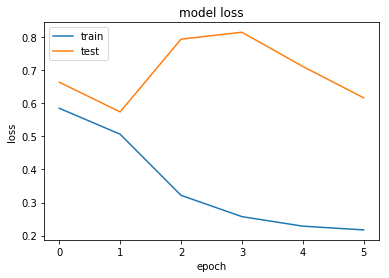

In [39]:
#Visualizing the model metrics (loss and accuracy)
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
#Using model for prediction
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

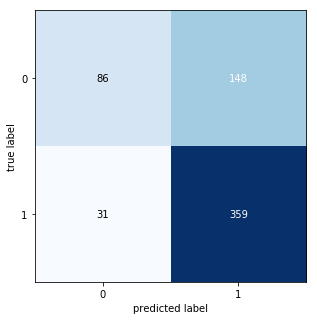

In [42]:
#Building confusion matrix
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [43]:
#Accuracy of the model is about 71%
359/(359+148)

0.7080867850098619

In [44]:
#The recall of the model is about 92%
359/ (359 + 31)

0.9205128205128205